In [47]:
#pip install seaborn

In [4]:
#import packages
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from PIL import Image
import glob
import PIL
import os.path
import cv2
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing
import sklearn.metrics as skmet
import itertools
from keras.models import load_model

In [5]:
# Get paths for infected and uninfected cells
paratisized_path = "C:/Users/USER/Malaria Cell/cell_images/cell_images/Parasitized"
uninfected_path = "C:/Users/USER/Malaria Cell/cell_images/cell_images/Uninfected"

paratisized_files = glob.glob(os.path.join(paratisized_path, "*.png"))
uninfected_files = glob.glob(os.path.join(uninfected_path, "*.png"))

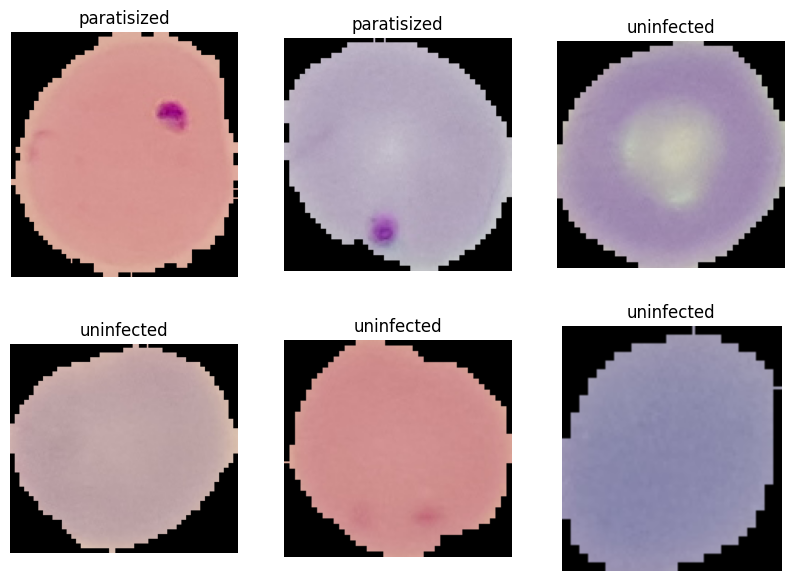

In [6]:
# Combine and shuffle the file paths into a dataframe
np.random.seed(42)
files_df = pd.DataFrame({
    'filename': paratisized_files + uninfected_files,
    'label': ['paratisized'] * len(paratisized_files) + ['uninfected'] * len(uninfected_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

# Display multiple images in one figure
fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 3

for i in range(6):
    img = Image.open(files_df.iloc[i, 0])
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(files_df.iloc[i, 1])

In [7]:
# Resize and preprocess the images
resized_df = []
labels_names = []

for i in range(len(files_df)):
    img_array = cv2.imread(files_df.iloc[i, 0])
    img = Image.fromarray(img_array, 'RGB')
    img_resized = img.resize((50,50), Image.ANTIALIAS)
    resized_df.append(np.array(img_resized))
    labels_names.append(files_df.iloc[i, 1])

labels_recoded = np.array([1 if name == "paratisized" else 0 for name in labels_names])
data = np.array(resized_df).astype(np.float32) / 255.0
labels = labels_recoded.astype(np.int32)

C:\Users\USER\AppData\Local\Temp\ipykernel_25900\1280041646.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize((50,50), Image.ANTIALIAS)


In [8]:
# Split data set into train, validation and test data using 60:10:30 split
train_data, test_data, train_labels, test_labels = train_test_split(data,
                                                                    labels, 
                                                                    test_size=0.3,
                                                                    random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data,
                                                                  train_labels,
                                                                  test_size=0.1,
                                                                  random_state=42)


In [9]:
print(f"Train files: {len(train_data)} \nVal files: {len(val_data)} \nTest files: {len(test_data)}")
print(f"Train labels: {len(train_labels)} \nVal labels: {len(val_labels)} \nTest labels: {len(test_labels)}")

Train files: 17361 
Val files: 1929 
Test files: 8268
Train labels: 17361 
Val labels: 1929 
Test labels: 8268


In [13]:
#Define input shape
input_shape = (50, 50, 3)

# Loading the VGG-19 model 
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", 
                                        input_shape=input_shape)

# Freeze the layers
vgg.trainable = False
    
# Attach head of Dense layers to perform the classification
# and added layers.BatchNormalization()#
model1 = keras.Sequential([
    vgg,
    layers.Flatten(),
    layers.Dense(units=512, activation="relu"),
    layers.Dropout(rate=0.3),
    layers.Dense(units=512, activation="relu"),
    layers.Dropout(rate=0.3),
    layers.Dense(1, activation="sigmoid")
])

print("Total Layers:", len(model1.layers))
print("Total trainable layers:", 
      sum([1 for l in model1.layers if l.trainable]))
    
# Specify loss function to be minimized & performance metrics
model1.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                loss="binary_crossentropy",
                metrics=["accuracy"])
model1.summary()

Total Layers: 7
Total trainable layers: 6
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dens

In [ ]:
# Define parameters for early stopping and learning scheduler

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=2, 
    monitor='val_loss', 
    restore_best_weights=True
)


lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001, # minimum amount of change to count as an improvement
    cooldown=0,
    min_lr=0
)

In [15]:
#Train model1
history1 = model1.fit(train_data,
                      train_labels, 
                      validation_data=(val_data, val_labels),
                      batch_size=64,
                      epochs=25,
                      verbose=1,
                      callbacks=[early_stopping, lr_scheduler])

model1.save("Model1.h5")

Epoch 1/25
272/272 [==============================] - 658s 2s/step - loss: 0.4484 - accuracy: 0.7916 - val_loss: 0.3167 - val_accuracy: 0.8533 - lr: 1.0000e-04
Epoch 2/25
272/272 [==============================] - 740s 3s/step - loss: 0.3115 - accuracy: 0.8672 - val_loss: 0.2854 - val_accuracy: 0.8714 - lr: 1.0000e-04
Epoch 3/25
272/272 [==============================] - 719s 3s/step - loss: 0.2851 - accuracy: 0.8791 - val_loss: 0.2700 - val_accuracy: 0.8844 - lr: 1.0000e-04
Epoch 4/25
272/272 [==============================] - 754s 3s/step - loss: 0.2717 - accuracy: 0.8854 - val_loss: 0.2561 - val_accuracy: 0.8901 - lr: 1.0000e-04
Epoch 5/25
272/272 [==============================] - 559s 2s/step - loss: 0.2594 - accuracy: 0.8925 - val_loss: 0.2461 - val_accuracy: 0.8906 - lr: 1.0000e-04
Epoch 6/25
272/272 [==============================] - 513s 2s/step - loss: 0.2526 - accuracy: 0.8955 - val_loss: 0.2463 - val_accuracy: 0.8901 - lr: 1.0000e-04
Epoch 7/25
272/272 [====================

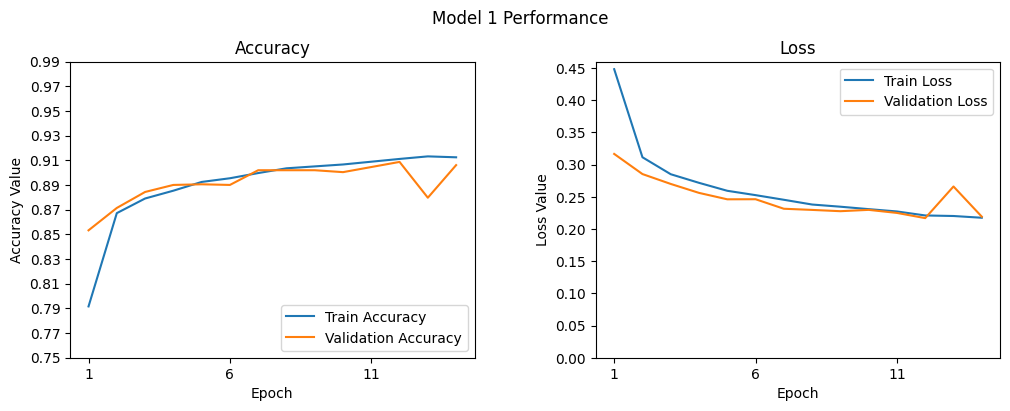

In [18]:
# Plot model1 performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = fig.suptitle("Model 1 Performance", fontsize=12)
fig.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history1.history["accuracy"]) + 1
epoch_list = list(range(1, max_epoch))
ax1.plot(epoch_list, history1.history["accuracy"], label="Train Accuracy")
ax1.plot(epoch_list, history1.history["val_accuracy"], label="Validation Accuracy")
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_yticks(np.arange(0.75, 1, 0.02))
ax1.set_ylabel("Accuracy Value")
ax1.set_xlabel("Epoch")
ax1.set_title("Accuracy")
ax1.legend(loc=4)

ax2.plot(epoch_list, history1.history["loss"], label="Train Loss")
ax2.plot(epoch_list, history1.history["val_loss"], label="Validation Loss")
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_yticks(np.arange(0.0, 0.5, 0.05))
ax2.set_ylabel("Loss Value")
ax2.set_xlabel("Epoch")
ax2.set_title("Loss")
ax2.legend(loc="best")

In [20]:
#Model 1 maximum validation accuracy
history1_frame = pd.DataFrame(history1.history)
print("Model 1 maximum validation accuracy: {}".format(history1_frame["val_accuracy"].max()))

Model 1 maximum validation accuracy: 0.9087610244750977


In [22]:
#evaluate model 1 on test data

test_loss, test_accuracy = model1.evaluate(test_data, test_labels)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

259/259 [==============================] - 336s 1s/step - loss: 0.2153 - accuracy: 0.9141
Test loss: 0.21533718705177307
Test accuracy: 0.9141267538070679


259/259 [==============================] - 348s 1s/step
Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.91      0.92      0.91      4075
 Parasitized       0.92      0.91      0.91      4193

    accuracy                           0.91      8268
   macro avg       0.91      0.91      0.91      8268
weighted avg       0.91      0.91      0.91      8268

Specificity for Model1: 0.92
AUC for Model1: 0.91


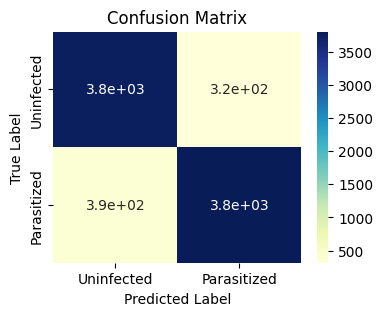

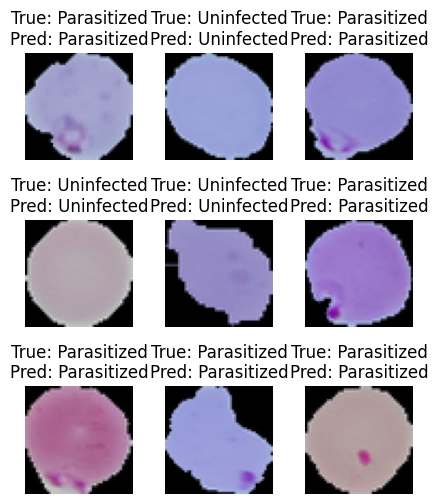

In [65]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Load the saved model
model1 = keras.models.load_model('Model1.h5')

# Make predictions on the test data
y_pred1 = model1.predict(test_data)
y_pred1 = np.round(y_pred1).astype(int).flatten()

# Get the classification report and confusion matrix
class_names1 = ["Uninfected", "Parasitized"]
print("Classification Report:")
print(classification_report(test_labels, y_pred1, target_names=class_names1))

# cm = confusion_matrix(test_labels, y_pred1)
# plt.figure(figsize=(4,3))
# sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=class_names1, yticklabels=class_names1)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')

cm = confusion_matrix(test_labels, y_pred1)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, cmap='YlGnBu', xticklabels=class_names1, yticklabels=class_names1)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Calculate specificity and AUC
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
fpr, tpr, thresholds = roc_curve(test_labels, y_pred1)
auc = roc_auc_score(test_labels, y_pred1)

print("Specificity for Model1: {:.2f}".format(specificity))
print("AUC for Model1: {:.2f}".format(auc))

# Show the images with true and predicted labels
fig, axs = plt.subplots(3, 3, figsize=(5, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, ax in enumerate(axs.flat):
    ax.imshow(test_data[i])
    ax.set_title(f"True: {class_names2[test_labels[i]]}\nPred: {class_names2[y_pred1[i]]}")
    ax.axis('off')

plt.show()


##### Improving Model 1 by adding adam optimizer

In [23]:
# Define the model architecture
model1_1 = keras.Sequential([
    vgg,
    layers.Flatten(),
    layers.Dense(units=512, activation="relu"),
    layers.Dropout(rate=0.3),
    layers.Dense(units=512, activation="relu"),
    layers.Dropout(rate=0.3),
    layers.Dense(1, activation="sigmoid")
])
model1_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [24]:
#compile the model
model1_1.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [25]:
#Train model1_1
history1_1 = model1_1.fit(train_data,
                      train_labels, 
                      validation_data=(val_data, val_labels),
                      batch_size=64,
                      epochs=25,
                      verbose=1,
                      callbacks=[early_stopping, lr_scheduler])

model1_1.save("Model1_1.h5")

Epoch 1/25
272/272 [==============================] - 724s 3s/step - loss: 0.3331 - accuracy: 0.8534 - val_loss: 0.2711 - val_accuracy: 0.8787 - lr: 0.0010
Epoch 2/25
272/272 [==============================] - 901s 3s/step - loss: 0.2656 - accuracy: 0.8893 - val_loss: 0.2328 - val_accuracy: 0.8999 - lr: 0.0010
Epoch 3/25
272/272 [==============================] - 678s 2s/step - loss: 0.2515 - accuracy: 0.8953 - val_loss: 0.2344 - val_accuracy: 0.8989 - lr: 0.0010
Epoch 4/25
272/272 [==============================] - 844s 3s/step - loss: 0.2411 - accuracy: 0.9004 - val_loss: 0.2253 - val_accuracy: 0.8999 - lr: 0.0010
Epoch 5/25
272/272 [==============================] - 945s 3s/step - loss: 0.2345 - accuracy: 0.9039 - val_loss: 0.2216 - val_accuracy: 0.9041 - lr: 0.0010
Epoch 6/25
272/272 [==============================] - 818s 3s/step - loss: 0.2331 - accuracy: 0.9059 - val_loss: 0.2233 - val_accuracy: 0.9051 - lr: 0.0010
Epoch 7/25
272/272 [==============================] - 981s 4s/st

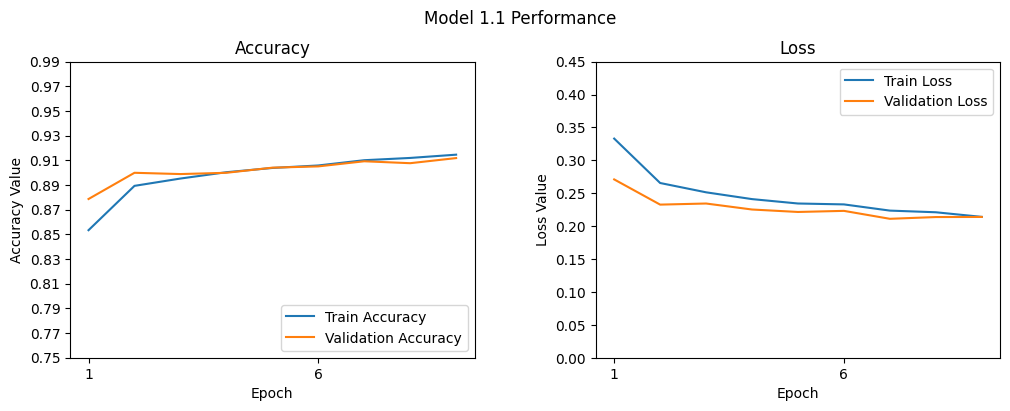

In [26]:
# Plot the performance metrics for model1_1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle("Model 1.1 Performance", fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history1_1.history["accuracy"]) + 1
epoch_list = list(range(1, max_epoch))

ax1.plot(epoch_list, history1_1.history["accuracy"], label="Train Accuracy")
ax1.plot(epoch_list, history1_1.history["val_accuracy"], label="Validation Accuracy")
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_yticks(np.arange(0.75, 1, 0.02))
ax1.set_ylabel("Accuracy Value")
ax1.set_xlabel("Epoch")
ax1.set_title("Accuracy")
l1 = ax1.legend(loc=4)

ax2.plot(epoch_list, history1_1.history["loss"], label="Train Loss")
ax2.plot(epoch_list, history1_1.history["val_loss"], label="Validation Loss")
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_yticks(np.arange(0.0, 0.5, 0.05))
ax2.set_ylabel("Loss Value")
ax2.set_xlabel("Epoch")
ax2.set_title("Loss")
l2 = ax2.legend(loc="best")

In [27]:
#Mode1_1 maximum validation accuracy
history1_1_frame = pd.DataFrame(history1_1.history)
print("Model 1.1 maximum validation accuracy: {}".format(history1_1_frame["val_accuracy"].max()))

Model 1.1 maximum validation accuracy: 0.9118714332580566


259/259 [==============================] - 410s 2s/step
Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.91      0.92      0.91      4075
 Parasitized       0.92      0.91      0.92      4193

    accuracy                           0.91      8268
   macro avg       0.91      0.91      0.91      8268
weighted avg       0.91      0.91      0.91      8268

Specificity for Model1_1: 0.92
AUC for Model1_1: 0.91


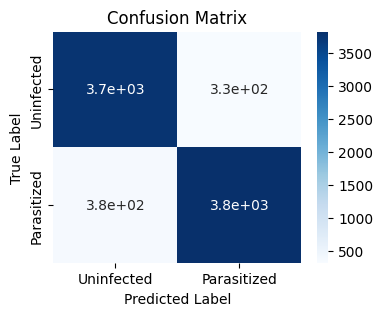

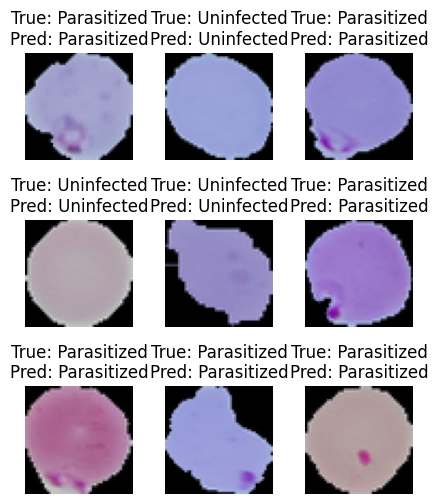

In [66]:
#Confusion matrix, classification report and predictions, specificity and AUC

# Load the saved model
model1_1 = keras.models.load_model('Model1_1.h5')

# Make predictions on the test data
y_pred1_1 = model1_1.predict(test_data)
y_pred1_1 = np.round(y_pred1_1).astype(int).flatten()

# Get the classification report, confusion matrix, ROC score, and specificity
class_names1_1 = ["Uninfected", "Parasitized"]
print("Classification Report:")
print(classification_report(test_labels, y_pred1_1, target_names=class_names1_1))

cm = confusion_matrix(test_labels, y_pred1_1)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=class_names1_1, yticklabels=class_names1_1)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Calculate specificity and AUC
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
fpr, tpr, thresholds = roc_curve(test_labels, y_pred1_1)
auc = roc_auc_score(test_labels, y_pred1_1)

print("Specificity for Model1_1: {:.2f}".format(specificity))
print("AUC for Model1_1: {:.2f}".format(auc))

# Show the images with true and predicted labels
fig, axs = plt.subplots(3, 3, figsize=(5, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, ax in enumerate(axs.flat):
    ax.imshow(test_data[i])
    ax.set_title(f"True: {class_names[test_labels[i]]}\nPred: {class_names[y_pred1_1[i]]}")
    ax.axis('off')

plt.show()


###### VGG19 Model 2 - Data Augumentation and Fine Tuning

In [31]:
#Data Augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range = 0.05, 
                                                                rotation_range = 25,
                                                                width_shift_range = 0.05, 
                                                                height_shift_range = 0.05, 
                                                                shear_range = 0.05,
                                                                horizontal_flip = True, 
                                                                fill_mode = "nearest")

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()


# build image augmentation generators
train_generator = train_datagen.flow(train_data, train_labels, batch_size = 64, shuffle = True)
val_generator = val_datagen.flow(val_data, val_labels, batch_size = 64, shuffle = False)

In [33]:
#using imagenet &freeze layers

vgg = tf.keras.applications.vgg19.VGG19(include_top = False, weights = "imagenet", 
                                        input_shape = input_shape)

# Freeze the layers
vgg.trainable = True

set_trainable = False
for layer in vgg.layers:
    if layer.name in ["block5_conv1", "block4_conv1"]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
# building the model
model2 = keras.Sequential([
    vgg,
    layers.Flatten(),
    layers.Dense(units = 512, activation = "relu"),
    layers.Dropout(rate = 0.3),
    layers.Dense(units = 512, activation = "relu"),
    layers.Dropout(rate = 0.3),
    layers.Dense(1, activation = "sigmoid")
])
model2.summary()

model2.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5),
                loss = "binary_crossentropy",
                metrics = ["accuracy"])

print("Total Layers:", len(model2.layers))
print("Total trainable layers:", sum([1 for l in model2.layers if l.trainable]))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 1)                

In [34]:
#training the model
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size

history2 = model2.fit_generator(train_generator,
                                steps_per_epoch = train_steps_per_epoch,
                                epochs = 25,
                                validation_data = val_generator,
                                validation_steps = val_steps_per_epoch, 
                                callbacks = [early_stopping, lr_scheduler])


model2.save("Model2.h5")

C:\Users\USER\AppData\Local\Temp\ipykernel_25900\739577297.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model2.fit_generator(train_generator,


Epoch 1/25
271/271 [==============================] - 2164s 8s/step - loss: 0.2895 - accuracy: 0.8726 - val_loss: 0.1407 - val_accuracy: 0.9469 - lr: 1.0000e-05
Epoch 2/25
271/271 [==============================] - 2103s 8s/step - loss: 0.1790 - accuracy: 0.9339 - val_loss: 0.1481 - val_accuracy: 0.9396 - lr: 1.0000e-05
Epoch 3/25
271/271 [==============================] - 1909s 7s/step - loss: 0.1589 - accuracy: 0.9423 - val_loss: 0.1267 - val_accuracy: 0.9604 - lr: 1.0000e-05
Epoch 4/25
271/271 [==============================] - 2386s 9s/step - loss: 0.1465 - accuracy: 0.9483 - val_loss: 0.1070 - val_accuracy: 0.9599 - lr: 1.0000e-05
Epoch 5/25
271/271 [==============================] - 2352s 9s/step - loss: 0.1368 - accuracy: 0.9500 - val_loss: 0.1066 - val_accuracy: 0.9656 - lr: 1.0000e-05
Epoch 6/25
271/271 [==============================] - 2065s 8s/step - loss: 0.1358 - accuracy: 0.9503 - val_loss: 0.1123 - val_accuracy: 0.9625 - lr: 1.0000e-05
Epoch 7/25
271/271 [==============

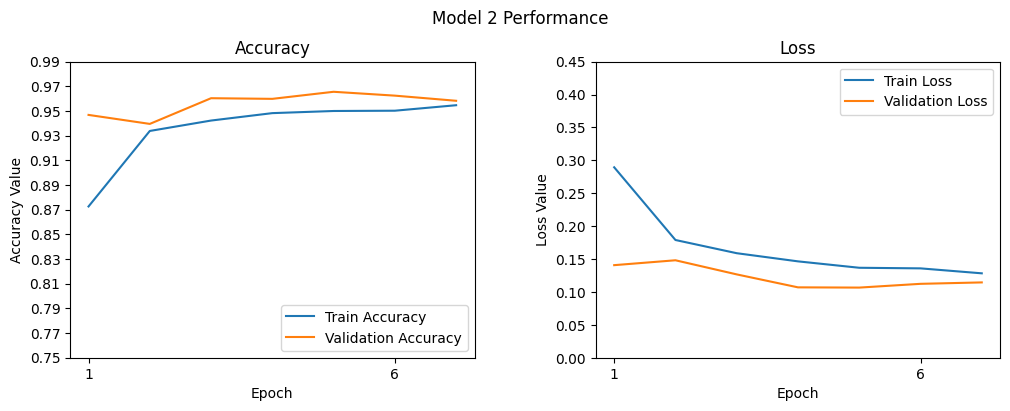

In [35]:
#Plot the training and validation performance
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
t = f.suptitle("Model 2 Performance", fontsize = 12)
f.subplots_adjust(top = 0.85, wspace = 0.3)

max_epoch = len(history2.history["accuracy"])+1
epoch_list = list(range(1, max_epoch))
ax1.plot(epoch_list, history2.history["accuracy"], label = "Train Accuracy")
ax1.plot(epoch_list, history2.history["val_accuracy"], label = "Validation Accuracy")
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_yticks(np.arange(0.75, 1, 0.02))
ax1.set_ylabel("Accuracy Value")
ax1.set_xlabel("Epoch")
ax1.set_title("Accuracy")
l1 = ax1.legend(loc = 4)

ax2.plot(epoch_list, history2.history["loss"], label = "Train Loss")
ax2.plot(epoch_list, history2.history["val_loss"], label = "Validation Loss")
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_yticks(np.arange(0.0, 0.5, 0.05))
ax2.set_ylabel("Loss Value")
ax2.set_xlabel("Epoch")
ax2.set_title("Loss")
l2 = ax2.legend(loc = "best")

In [36]:
#maxium validation accuracy
history2_frame = pd.DataFrame(history2.history)
print("Model 2 maximum validation accuracy: {}".format(history2_frame["val_accuracy"].max()))

Model 2 maximum validation accuracy: 0.965624988079071


259/259 [==============================] - 327s 1s/step
Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.95      0.97      0.96      4075
 Parasitized       0.97      0.95      0.96      4193

    accuracy                           0.96      8268
   macro avg       0.96      0.96      0.96      8268
weighted avg       0.96      0.96      0.96      8268

Specificity: 0.97
AUC: 0.96


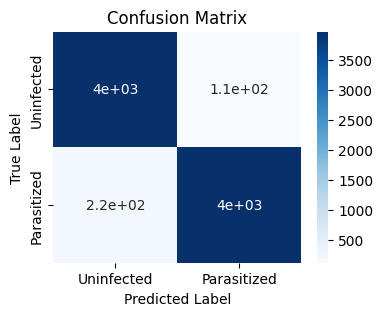

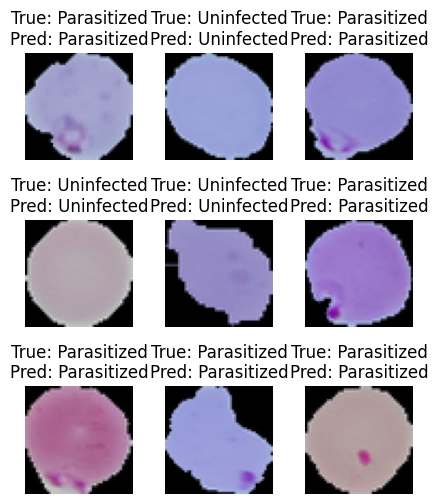

In [61]:
#Get the classification report, coonfusion matrix, predictions

# Load the saved model
model2 = keras.models.load_model('Model2.h5')

# Make predictions on the test data
y_pred2 = model2.predict(test_data)
y_pred2 = np.round(y_pred2).astype(int).flatten()

# Get the classification report and confusion matrix
class_names2 = ["Uninfected", "Parasitized"]
print("Classification Report:")
print(classification_report(test_labels, y_pred2, target_names=class_names2))

cm = confusion_matrix(test_labels, y_pred2)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=class_names2, yticklabels=class_names2)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Calculate specificity and AUC
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
fpr, tpr, thresholds = roc_curve(test_labels, y_pred2)
auc = roc_auc_score(test_labels, y_pred2)

print("Specificity: {:.2f}".format(specificity))
print("AUC: {:.2f}".format(auc))

# Show the images with true and predicted labels
fig, axs = plt.subplots(3, 3, figsize=(5, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, ax in enumerate(axs.flat):
    ax.imshow(test_data[i])
    ax.set_title(f"True: {class_names2[test_labels[i]]}\nPred: {class_names2[y_pred2[i]]}")
    ax.axis('off')

plt.show()


##### Improving Model 2 - Adam Optimizer

In [43]:
model2_2 = keras.Sequential([
    vgg,
    layers.Flatten(),
    layers.Dense(units = 512, activation = "relu"),
    layers.Dropout(rate = 0.3),
    layers.Dense(units = 512, activation = "relu"),
    layers.Dropout(rate = 0.3),
    layers.Dense(1, activation = "sigmoid")
])
model2_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 512)               262656    
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 512)               262656    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 1)                

In [69]:
model2_2.compile(optimizer = "adam",
                loss = "binary_crossentropy",
                metrics = ["accuracy"])

history2_2 = model2_2.fit_generator(
    train_generator, 
    steps_per_epoch = train_steps_per_epoch, 
    epochs = 25,
    validation_data = val_generator, 
    validation_steps = val_steps_per_epoch, 
    callbacks = [early_stopping, lr_scheduler])

model2_2.save("Model2_2.h5")

C:\Users\USER\AppData\Local\Temp\ipykernel_14044\430290177.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2_2 = model2_2.fit_generator(


Epoch 1/25
271/271 [==============================] - 1673s 6s/step - loss: 0.1595 - accuracy: 0.9454 - val_loss: 0.1213 - val_accuracy: 0.9615 - lr: 0.0010
Epoch 2/25
271/271 [==============================] - 1611s 6s/step - loss: 0.1486 - accuracy: 0.9491 - val_loss: 0.1409 - val_accuracy: 0.9609 - lr: 0.0010
Epoch 3/25
271/271 [==============================] - ETA: 0s - loss: 0.1597 - accuracy: 0.9461
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
271/271 [==============================] - 1633s 6s/step - loss: 0.1597 - accuracy: 0.9461 - val_loss: 0.1386 - val_accuracy: 0.9495 - lr: 0.0010


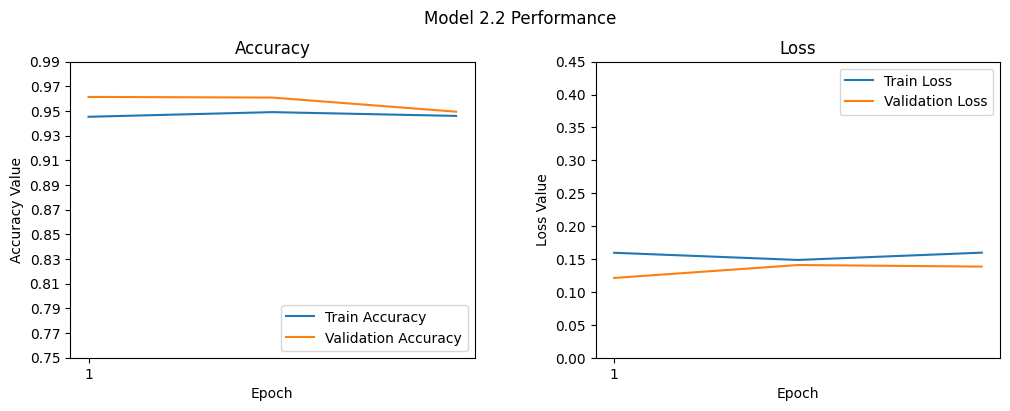

In [96]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
t = f.suptitle("Model 2.2 Performance", fontsize = 12)
f.subplots_adjust(top = 0.85, wspace = 0.3)

max_epoch = len(history2_2.history["accuracy"])+1
epoch_list = list(range(1, max_epoch))
ax1.plot(epoch_list, history2_2.history["accuracy"], label = "Train Accuracy")
ax1.plot(epoch_list, history2_2.history["val_accuracy"], label = "Validation Accuracy")
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_yticks(np.arange(0.75, 1, 0.02))
ax1.set_ylabel("Accuracy Value")
ax1.set_xlabel("Epoch")
ax1.set_title("Accuracy")
l1 = ax1.legend(loc = 4)

ax2.plot(epoch_list, history2_2.history["loss"], label = "Train Loss")
ax2.plot(epoch_list, history2_2.history["val_loss"], label = "Validation Loss")
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_yticks(np.arange(0.0, 0.5, 0.05))
ax2.set_ylabel("Loss Value")
ax2.set_xlabel("Epoch")
ax2.set_title("Loss")
l2 = ax2.legend(loc = "best")

259/259 [==============================] - 392s 2s/step
Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.91      0.92      0.91      4075
 Parasitized       0.92      0.91      0.91      4193

    accuracy                           0.91      8268
   macro avg       0.91      0.91      0.91      8268
weighted avg       0.91      0.91      0.91      8268



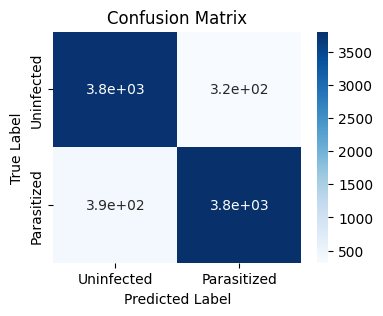

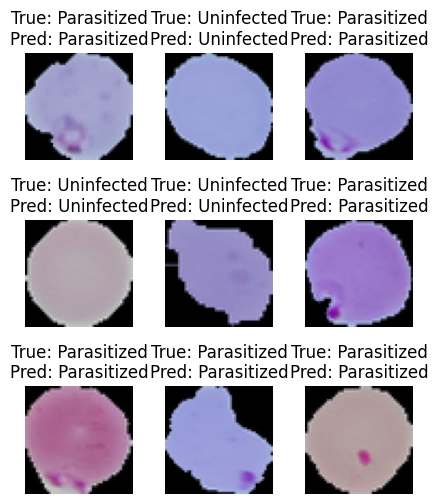

In [56]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the saved model
model2_2 = keras.models.load_model('Model2_2.h5')

# Make predictions on the test data
y_pred2_2 = model2_2.predict(test_data)
y_pred2_2 = np.round(y_pred).astype(int).flatten()

# Get the classification report and confusion matrix
class_names2_2 = ["Uninfected", "Parasitized"]
print("Classification Report:")
print(classification_report(test_labels, y_pred2_2, target_names=class_names2_2))

cm = confusion_matrix(test_labels, y_pred2_2)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=class_names2_2, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the images with true and predicted labels
fig, axs = plt.subplots(3, 3, figsize=(5, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, ax in enumerate(axs.flat):
    ax.imshow(test_data[i])
    ax.set_title(f"True: {class_names[test_labels[i]]}\nPred: {class_names[y_pred2_2[i]]}")
    ax.axis('off')

plt.show()
